In [1]:
from optimize import optimize
from signals import compute_features, detect_trade_signals
from backtester import Backtester

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [2]:
## commodity prices ##
commodities = pd.read_csv('../Data/raw/commodity_prices.csv',index_col=['Date'])
commodities.index = pd.to_datetime(commodities.index)

## stock prices ##
stocks = pd.read_csv('../Data/raw/stock_prices.csv',index_col=['Date'])
stocks.index = pd.to_datetime(stocks.index)


prices = commodities.merge(stocks, left_index=True, right_index=True)

### Test optimizer

In [3]:
# Example pair
commodity = prices['GC=F Close']
stock = prices['STX']

param_grid = {
    'threshold': np.linspace(0.2,1,25),
    'streak': [2, 4, 6],
    'quantile': np.linspace(0.2,1,25),
    'lag': [1,2],
    'window': [7,14,21]
}

results = optimize(commodity, stock, param_grid)
print(results.head(10))

     threshold  streak  quantile  final_return  lag  window
169   0.200000       4  0.300000      1.744116    1      14
163   0.200000       4  0.266667      1.739452    1      14
151   0.200000       4  0.200000      1.710153    1      14
157   0.200000       4  0.233333      1.701598    1      14
613   0.233333       4  0.266667      1.663615    1      14
757   0.233333       6  0.233333      1.632450    1      14
607   0.233333       4  0.233333      1.631937    1      14
601   0.233333       4  0.200000      1.616112    1      14
313   0.200000       6  0.266667      1.601665    1      14
751   0.233333       6  0.200000      1.585724    1      14


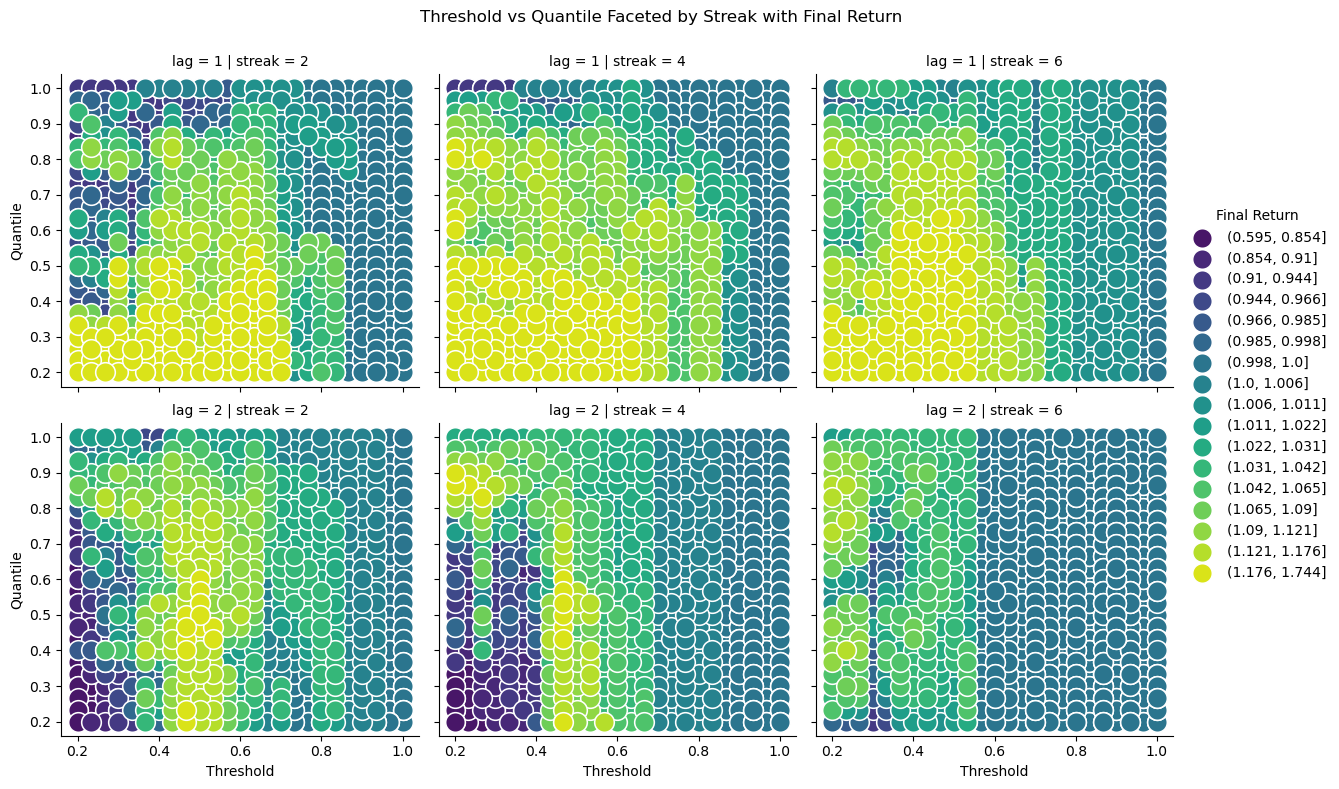

In [4]:
vmin = results['final_return'].min()
vmax = results['final_return'].max()
results['return_bin'] = pd.qcut(results['final_return'], q=25, duplicates='drop')

g = sns.FacetGrid(
    results, 
    col='streak',
    row='lag', 
    height=4, 
    sharex=True, 
    sharey=True,
    hue='return_bin',
    palette='viridis'   
)

g.map_dataframe(
    sns.scatterplot,
    x='threshold',
    y='quantile',
    size=None,
    s=200 
)


g.add_legend(title='Final Return')
g.set_axis_labels('Threshold', 'Quantile')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Threshold vs Quantile Faceted by Streak with Final Return')

plt.show()

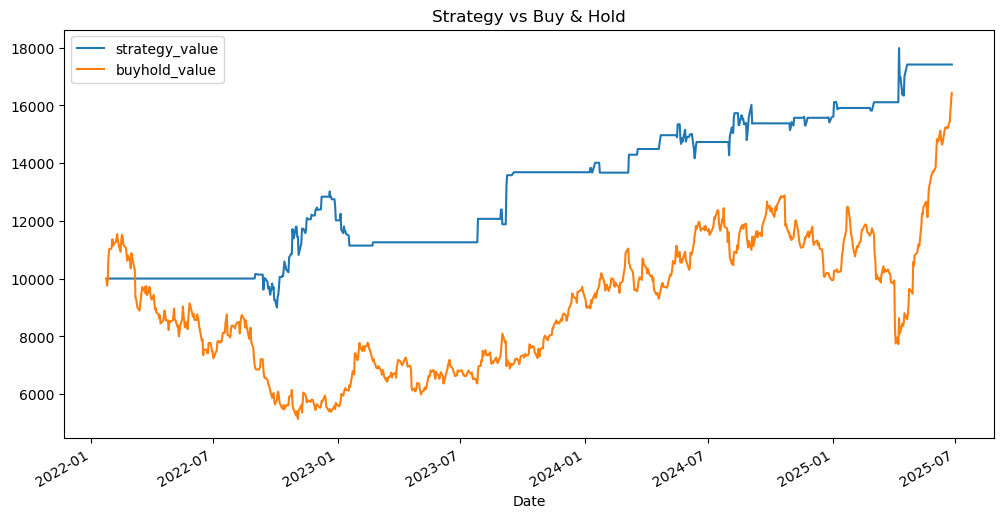

In [5]:
i = 0

threshold = results.iloc[i,:]['threshold']
min_streak = results.iloc[i,:]['streak']
quantile = results.iloc[i,:]['quantile']
lag = results.iloc[i,:]['lag']
window = int(results.iloc[i,:]['window'])


features_df = compute_features(commodity,stock,window,lag)
features_df['stock_price'] = stock
signals_df = detect_trade_signals(
    features_df, 
    threshold=threshold, 
    min_streak=min_streak, 
    quantile=quantile)

bt = Backtester(
    prices = features_df,
    signals = signals_df,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()


#### Split data into train and test 

In [6]:
commodity = 'GC=F Close'
stock = 'STX'

split = 600

train_commodity = prices.iloc[:split,:][commodity]
train_stock = prices.iloc[:split,:][stock]

test_commodity = prices.iloc[split:,:][commodity]
test_stock = prices.iloc[split:,:][stock]


results = optimize(train_commodity, train_stock, param_grid)
print(results.head(10))

      threshold  streak  quantile  final_return  lag  window
175    0.200000       4  0.333333      1.510052    1      14
4518   0.533333       2  0.300000      1.462937    1       7
169    0.200000       4  0.300000      1.461039    1      14
470    0.233333       2  0.300000      1.442982    1      21
163    0.200000       4  0.266667      1.426333    1      14
2550   0.366667       6  0.200000      1.410595    1       7
4524   0.533333       2  0.333333      1.401408    1       7
2556   0.366667       6  0.233333      1.399729    1       7
4512   0.533333       2  0.266667      1.397137    1       7
4506   0.533333       2  0.233333      1.395976    1       7


#### view method on unseen data

* completely fails

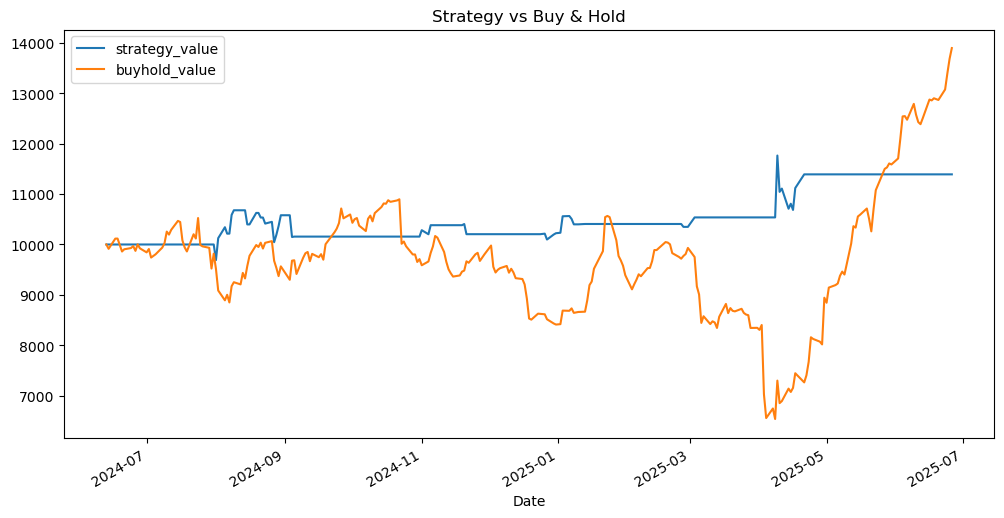

In [7]:
best_params = results.iloc[0] 

# Use best params on test data
features = compute_features(test_commodity, test_stock, window=int(best_params['window']), lag=best_params['lag'])
signals = detect_trade_signals(
    features,
    threshold=best_params['threshold'],
    min_streak=int(best_params['streak']),
    quantile=best_params['quantile'],
)

bt = Backtester(
    prices = features.assign(stock_price = test_stock),
    signals = signals,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()


#### let's see how it would have performed if I trained on test data

In [8]:
results = optimize(test_commodity, test_stock, param_grid)
print(results.head(10))

      threshold  streak  quantile  final_return  lag  window
307    0.200000       6  0.233333      1.223492    1      14
1525   0.300000       4  0.333333      1.220069    1      14
301    0.200000       6  0.200000      1.204794    1      14
1051   0.266667       4  0.200000      1.203310    1      14
313    0.200000       6  0.266667      1.200233    1      14
1531   0.300000       4  0.366667      1.198419    1      14
1057   0.266667       4  0.233333      1.196149    1      14
751    0.233333       6  0.200000      1.193468    1      14
319    0.200000       6  0.300000      1.193317    1      14
757    0.233333       6  0.233333      1.186365    1      14


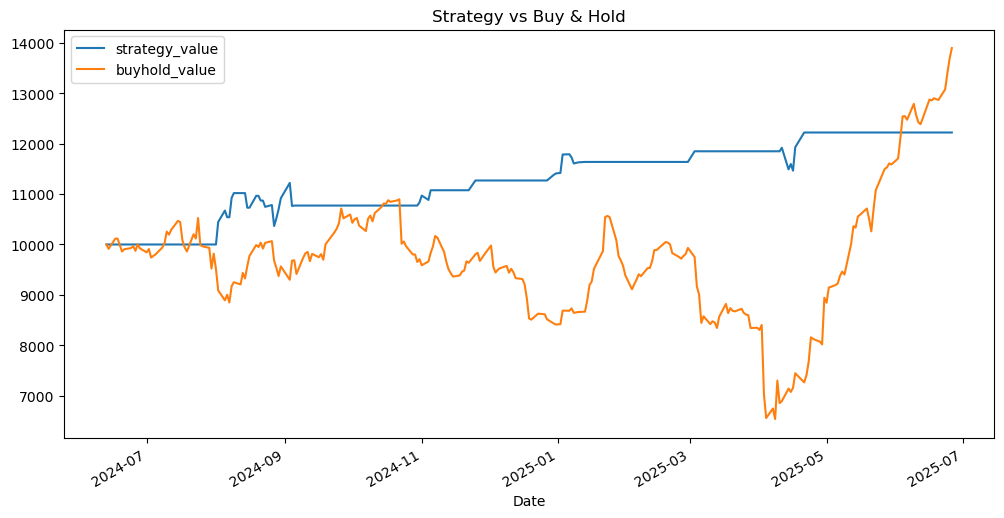

In [9]:
best_params = results.iloc[0] 

# Use best params on test data
features = compute_features(test_commodity, test_stock, window=int(best_params['window']), lag=best_params['lag'])
signals = detect_trade_signals(
    features,
    threshold=best_params['threshold'],
    min_streak=int(best_params['streak']),
    quantile=best_params['quantile'],
)

bt = Backtester(
    prices = features.assign(stock_price = test_stock),
    signals = signals,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()


### Method is failing - Overfitting

* it's a bad look
* correlations change
* thresholds are too low
* might try changing the window size of the rolling correlations